evaluate(401021, E, 5, 2019-8-1 14:00)

q= SELECT * from sensors  where user = 401021 and user2 = 5 and type = 'E'   and time > DATE_SUB('2019-8-1 14:00', INTERVAL 4 DAY) and time < '2019-8-1 14:00'   order by time, id 
got 5479 records
length=192


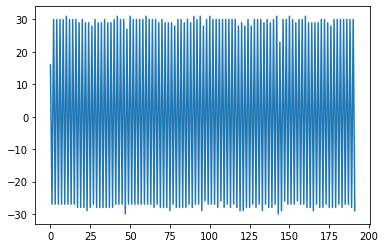

loading 401021E5.h5


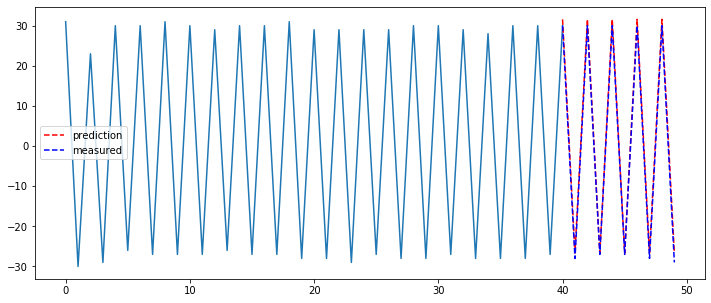

evaluate(401021, E, 5, 2019-8-1 14:00)
Query =  SELECT * from sensors  where user = 401021 and user2 = 5 and type = 'E'   and time > DATE_SUB('2019-8-1 14:00', INTERVAL 4 DAY) and time < '2019-8-1 14:00'   order by time, id 
5479 records
192 featured data records
loading model 401021E5.h5

Mean Squad Err=1.800758
measured[last]=-29.000000
predicted[last]=-26.672384
Incomplete last cycle within good range


In [5]:
# %load evaluate.py
#!/usr/bin/env python

# In[20]:


# 0. 사용할 패키지 불러오기
import keras
import pandas as pd 
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import mysql.connector
%matplotlib inline

look_ahead = 10
look_back = 40
signal_data = ""
measured_data = ""
predictions = ""

def translate(level):
    # Trim zero leader and trailer
    #i = 0
    #while not level[i]: i += 1
    #j = len(level-1)
    #while not level[i]: j -= 1
    #level = level[i:j-1]    

    seq = []
    
    old = level[0]
    c = 0
    for x in level:
        if x != old:
            if old > 0: seq.append(c)
            else: seq.append(-c)
            c = 1
        else:
            c += 1
        old = x
    if c > 0:
        if level[-1] > 0: seq.append(c)
        else: seq.append(-c)
    print("length=%d"%len(seq))
    return np.array(seq)

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def read_data(user, type, user2, time):
    global X, level, query
    if time != "": 
        timestr = " and time > DATE_SUB('%s', INTERVAL 4 DAY) and time < '%s' "%(time,time)
    else: 
        timestr = " and time > DATE_SUB(now(), INTERVAL 4 DAY) "
    query = (" SELECT * from sensors "
             " where user = %s and user2 = %s and type = '%s' "
             " %s "
             " order by time, id "%(user,user2,type,timestr))
    cnx = mysql.connector.connect(
        host="sensor.c2rirrernrhc.ap-northeast-2.rds.amazonaws.com",
        database="connware",
        user="sensor",
        passwd="sensor.Ann8#"
    )
    print("q=%s"%query)
    d = pd.read_sql(query, con=cnx)
    print("got %d records"%len(d))
    if len(d) < 1600:
        print("data < 1600")
    
    npd = np.array(d['value'])
    X = npd.reshape(len(d), 1)
    level = KMeans(n_clusters=2).fit_predict(X)

    v0 = -1
    v1 = -1
    for i in range(len(level)):
        if v0 == -1 and not level[i]: v0 = d['value'][i]
        if v1 == -1 and level[i]: v1 = d['value'][i]
        if v1 != -1 and v0 != -1: break

    if v0 > v1:
        print("switch label")
        for i in range(len(level)):
            if level[i]: level[i] = 0
            else: level[i] = 1    
    
    seq = translate(level)
    return seq[:,None]

def evaluate(user, type, user2, time):
    # 1. 데이터셋 생성하기
    global X, query, signal_data, measured_data, predictions
    ret = ""
    if time == "X": time = ""

    ret += "evaluate(%s, %s, %s, %s)\n"%(user, type, user2, time) 
    print(ret)

    signal_data = read_data(user,type, user2, time)
    plt.plot(signal_data)
    plt.show()
    ret += "Query = %s\n"%query
    ret += "%d records\n"%len(X)
    ret += "%d featured data records\n"%len(signal_data)
    
    fname = "%s%s%s.h5"%(user, type, user2)
    print("loading %s"%fname)
    ret += "loading model %s\n"%fname
    model = load_model(fname)
    
    # 데이터 전처리
    scaler = joblib.load("%s%s%s.joblib"%(user, type, user2))
    signal_data_fit = scaler.transform(signal_data)  
    
    # 데이터셋 전처리
    xhat = signal_data_fit[-look_back-look_ahead:-look_ahead]
    measured_data = signal_data[-look_ahead:]
    predictions = np.zeros((look_ahead,1))
  

    for i in range(look_ahead):
        prediction = model.predict(np.array([xhat]), batch_size=1)
        predictions[i] = prediction
        xhat = np.vstack([xhat[1:],prediction])
       
    plt.figure(figsize=(12,5))
    plt.plot(np.arange(0,look_back+1), signal_data[-look_back-look_ahead:-look_ahead+1])
    plt.plot(np.arange(look_back,look_back+look_ahead), scaler.inverse_transform(predictions),'r', linestyle='dashed', label="prediction")
    plt.plot(np.arange(look_back,look_back+look_ahead), measured_data,'b',linestyle='dashed', label="measured")
    
    #a = np.array([signal_data[-1], predictions[0]])
    #plt.plot(np.arange(look_back-1,look_back+1), a, 'g', linestyle='dashed')
    plt.legend()
    plt.show()
    
    err = mean_squared_error(measured_data[:-1], scaler.inverse_transform(predictions[:-1]))
    ret += "\nMean Squad Err=%f"%err
    ret += "\nmeasured[last]=%f"%measured_data[-1]
    ret += "\npredicted[last]=%f"%scaler.inverse_transform(predictions)[-1]
    if abs(measured_data[-1]) > abs(scaler.inverse_transform(predictions)[-1]*1.2):
        ret += "\nAlready longer downtime"
        err += 1000
        ret += "\nEscallated Err=%f"%err
    else:
        ret += "\nIncomplete last cycle within good range"
    
    plt.close("all")
    keras.backend.clear_session()
    return err, ret

if __name__ == "__main__":
    # execute only if run as a script
    user = '401021'
    type = 'E'
    user2 = '5'
    time =  '2019-8-1 14:00'
    # evaluate('401021', 'E', '0', '2019-7-21 12:00')
    err, ret = evaluate(user, type, user2, time)
    print(ret)
    if err > 100:
        print("Alarm - Non Regular Motor Operation Detected")


In [3]:
abs(measured_data[-1]) > abs(scaler.inverse_transform(predictions)[-1]*1.1)

NameError: name 'scaler' is not defined